<a href="https://colab.research.google.com/github/ZlatanSU87/Graduate-work.-Forecast-for-the-cafe-chain/blob/main/cafe_f_engin_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

import plotly.express as px

from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime

import os
import gc
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', rc={'figure.figsize': (10, 5)})

# настройки вывода pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.precision', 2)

# Путь к файлу на Google Drive
INPUT_CSV = '/content/drive/MyDrive/Cafe_prediction/cafe_preprocessing.csv'
OUTPUT_CSV = '/content/drive/MyDrive/Cafe_prediction/cafe_f_engin_EDA.csv'
save_dir = '/content/drive/MyDrive/Cafe_prediction/cafe_plots'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(INPUT_CSV)

#### Выделим временные промежутки работы кафе

In [ ]:
def assign_day_time(df, time_col='Время открытия', out_col='day_time', tz=None):
    s = df[time_col]
    # если колонка не datetimelike, конвертируем (один раз)
    if not pd.api.types.is_datetime64_any_dtype(s):
        df[time_col] = pd.to_datetime(s, errors='coerce')
        s = df[time_col]

    # при необходимости локализуем/конвертируем временную зону
    if tz is not None:
        if s.dt.tz is None:
            df[time_col] = s.dt.tz_localize(tz)
        else:
            df[time_col] = s.dt.tz_convert(tz)
        s = df[time_col]

    hours = s.dt.hour
    minutes = s.dt.minute
    mins = hours.mul(60).add(minutes)  # минуты с полуночи

    conds = [
        (mins >= 420)  & (mins < 600),   # 07:00 - 10:00
        (mins >= 600)  & (mins < 720),   # 10:00 - 12:00
        (mins >= 720)  & (mins < 870),   # 12:00 - 14:30
        (mins >= 870)  & (mins < 1020),  # 14:30 - 17:00
        (mins >= 1020) & (mins < 1200),  # 17:00 - 20:00
    ]
    labels = ['Завтрак', 'Ланч', 'Обед', 'Полдник', 'Ужин']

    df[out_col] = np.select(conds, labels, default='Поздний ужин')
    df[out_col] = df[out_col].astype('category')
    return df

In [ ]:
df = assign_day_time(df)

Проведем дополнительные преобразования для EDA

In [ ]:
df = df.rename(columns={'Время открытия': 'ts'})

In [ ]:
df['date'] = df['ts'].dt.date
df['day'] = df['ts'].dt.day
df['month'] = df['ts'].dt.month
df['year'] = df['ts'].dt.year
df['weekofyear'] = df['ts'].dt.isocalendar().week.astype('int16')
df['is_month_start'] = df['ts'].dt.is_month_start.astype('int8')
df['is_month_end'] = df['ts'].dt.is_month_end.astype('int8')
df['quarter'] = df['ts'].dt.quarter.astype('int8')

df['season'] = ((df['month']%12 + 3)//3).astype('int8')

df['hour'] = pd.to_datetime(df['ts']).dt.hour.astype('int8')
df['dow'] = pd.to_datetime(df['ts']).dt.dayofweek.astype('int8')
df['is_weekend'] = df['dow'].isin([5,6]).astype('int8')

In [ ]:
# фичи, связанные с погодой
# бинарные флаги
df['precip_flag'] = (df['precip'] > 0).astype('int8')
df['rain_flag'] = (df['rain'] > 0).astype('int8')
df['snow_flag'] = (df['snow'] > 0).astype('int8')

# температурные бины
temp_bins = [-40, -10, 0, 5, 10, 15, 20, 25, 40]
temp_labels = ['<-10','-10..0','0..5','5..10','10..15','15..20','20..25','>25']
df['t_bin'] = pd.cut(df['t_mean'], bins=temp_bins, labels=temp_labels)

# экстремальные погодные условия
df['hot'] = (df['t_mean'] >= 25).astype('int8')
df['cold'] = (df['t_mean'] <= -15).astype('int8')
df['windy'] = (df['wind_max'] >= 10).astype('int8')  # порог в м/с — настройте
df['icy_snow'] = ((df['snowfall_sum'] > 0) & (df['t_mean'] < 1)).astype('int8')

# скользящие погодные средние
# сначала создадим индекс по времени (нужно для rolling с временными метками)
df_sorted = df.sort_values('ts')


In [ ]:
# Агрегации: ежедневные/недельные/месячные/полугодовые/годовые показатели (по Торговое предприятие и глобально)
# Колонки, которые считаем как target:
# - demand: sum кол-ва блюд (Кол-во блюд)
# - revenue: sum 'Сумма со скидкой, р.'
REVENUE_COL = 'Сумма со скидкой, р.'
QTY_COL = 'Количество блюд'
STORE_COL = 'Торговое предприятие'

# Функция агрегирования по любому frequency
def aggregate_by_freq(df_sorted, freq='D', store=None):
    """
    Возвращает агрегированные метрики по частоте freq.
    freq как в pd.Grouper: 'D','W-MON','M','6M','Y'
    Если store задан, фильтрует по нему.
    """
    sub = df_sorted if store is None else df_sorted[df_sorted[STORE_COL] == store]
    # группируем по дате (по ts)
    agg = (sub
           .groupby(pd.Grouper(key='ts', freq=freq))
           .agg({
               QTY_COL: 'sum',
               REVENUE_COL: 'sum',
               'hour': 'mean',         # вспомогательные
               't_mean': 'mean',
               'precip': 'sum',
               'rain': 'sum',
               'snow': 'sum',
               'wind_mean': 'mean',
               'humidity': 'mean'
           })
          ).rename(columns={QTY_COL: 'demand', REVENUE_COL: 'revenue'})
    agg = agg.reset_index()
    agg['date'] = agg['ts'].dt.date
    return agg

# ежедневная (D) и месячная (M) агрегация по всем и по магазину
agg_daily_all = aggregate_by_freq(df_sorted, freq='D', store=None)
agg_monthly_all = aggregate_by_freq(df, freq='M', store=None)

# для одного магазина
top_store = df_sorted[STORE_COL].value_counts().index[0]
agg_daily_store = aggregate_by_freq(df_sorted, freq='D', store=top_store)

agg_daily_all.head()

ts  demand  revenue   hour  t_mean  precip     rain  \
0 2021-04-06 00:00:00+03:00      78   7258.0  17.83    1.94   165.0   165.00   
1 2021-04-07 00:00:00+03:00     192  16992.0  14.51    1.59   158.4    72.16   
2 2021-04-08 00:00:00+03:00     180  16449.0  14.47    0.73  1039.5   358.05   
3 2021-04-09 00:00:00+03:00     673  57411.0  14.38    1.09   906.0   525.48   
4 2021-04-10 00:00:00+03:00     394  31625.0  15.51    2.88  1808.8  1424.43   

     snow  wind_mean  humidity        date  
0    0.00      17.81     76.58  2021-04-06  
1   86.24      14.70     72.38  2021-04-07  
2  681.45      13.43     87.42  2021-04-08  
3  380.52      20.23     71.25  2021-04-09  
4  384.37      23.85     82.17  2021-04-10

In [ ]:
agg_monthly_all.head()

ts  demand   revenue   hour  t_mean    precip  \
0 2021-04-30 00:00:00+03:00   13181  1.08e+06  14.68    3.30   17048.5   
1 2021-05-31 00:00:00+03:00   18346  1.61e+06  14.83   10.55   44586.9   
2 2021-06-30 00:00:00+03:00   21732  2.12e+06  14.79   19.09   43303.0   
3 2021-07-31 00:00:00+03:00   31156  3.32e+06  15.24   20.22   33373.8   
4 2021-08-31 00:00:00+03:00   31857  3.20e+06  15.15   15.56  142679.7   

        rain     snow  wind_mean  humidity        date  
0   12567.73  4480.77      11.97     71.39  2021-04-30  
1   39187.10  5399.80      13.04     72.60  2021-05-31  
2   43303.00     0.00      11.32     63.51  2021-06-30  
3   33373.80     0.00      11.11     64.08  2021-07-31  
4  142679.70     0.00      13.64     79.92  2021-08-31

In [ ]:
agg_daily_store.head()

ts  demand  revenue   hour  t_mean  precip     rain  \
0 2021-04-06 00:00:00+03:00      78   7258.0  17.83    1.94   165.0   165.00   
1 2021-04-07 00:00:00+03:00     192  16992.0  14.51    1.59   158.4    72.16   
2 2021-04-08 00:00:00+03:00     180  16449.0  14.47    0.73  1039.5   358.05   
3 2021-04-09 00:00:00+03:00     673  57411.0  14.38    1.09   906.0   525.48   
4 2021-04-10 00:00:00+03:00     394  31625.0  15.51    2.88  1808.8  1424.43   

     snow  wind_mean  humidity        date  
0    0.00      17.81     76.58  2021-04-06  
1   86.24      14.70     72.38  2021-04-07  
2  681.45      13.43     87.42  2021-04-08  
3  380.52      20.23     71.25  2021-04-09  
4  384.37      23.85     82.17  2021-04-10

In [ ]:
def save_plot(fig=None, filename='plot', dirpath=save_dir, dpi=150, tight=True, ext='png'):
    """
    Сохраняет текущую фигуру.
    """
    if fig is None:
        fig = plt.gcf()
    os.makedirs(dirpath, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S_%f')
    filepath = os.path.join(dirpath, f"{filename}_{timestamp}.{ext}")
    fig.savefig(filepath, dpi=dpi, bbox_inches='tight' if tight else None)
    print(f"Saved: {filepath}")
    return filepath


Saved: /content/drive/MyDrive/Cafe_prediction/cafe_plots/Общее число проданных блюд и выручка по дате_20251002_192803_679716.png
Saved: /content/drive/MyDrive/Cafe_prediction/cafe_plots/Распределение спроса по дням недели (сумма за день)_20251002_192804_452851.png


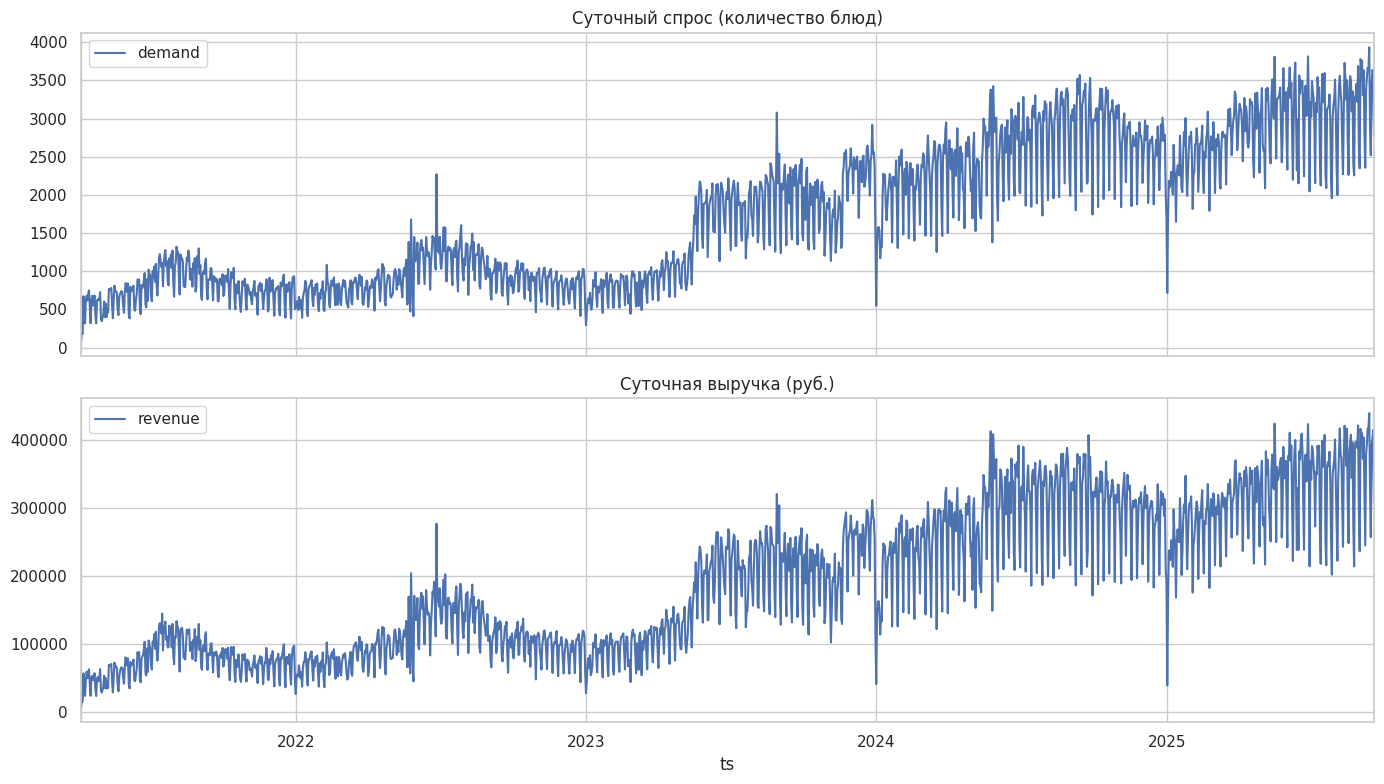

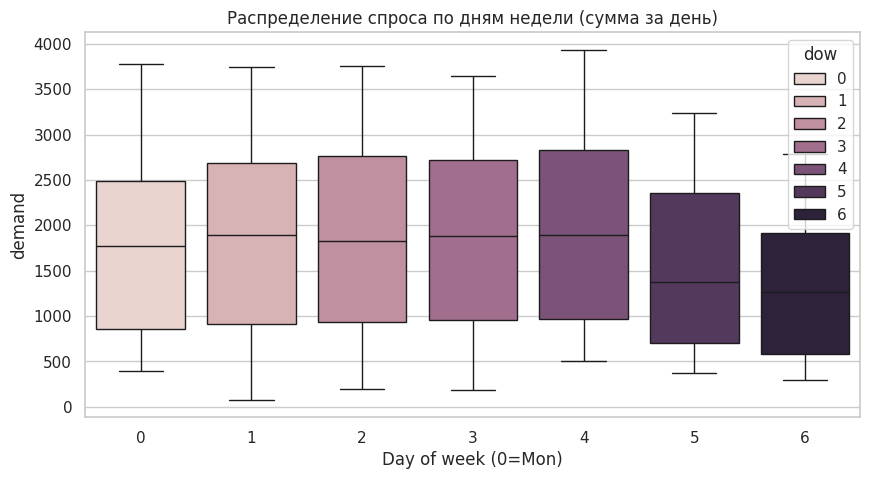

Saved: /content/drive/MyDrive/Cafe_prediction/cafe_plots/Hour vs DOW: суммарное количество блюд_20251002_192805_786079.png


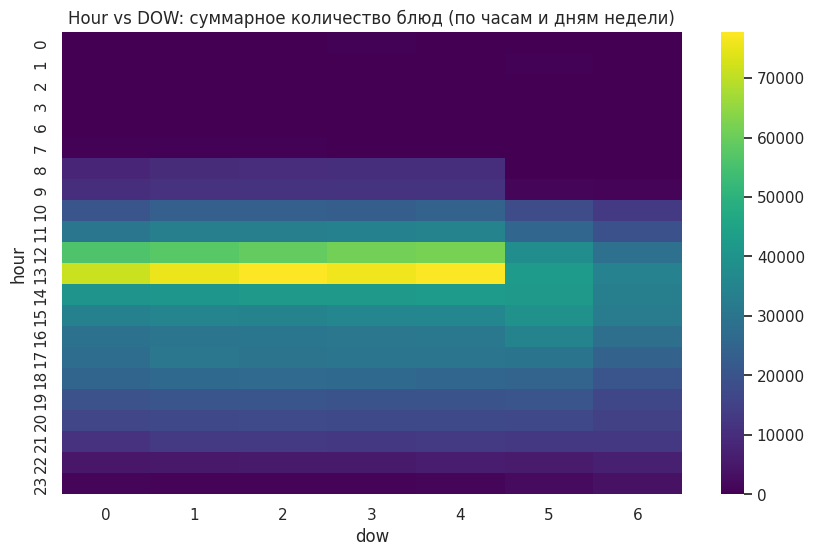

Saved: /content/drive/MyDrive/Cafe_prediction/cafe_plots/Корреляции (день): спрос и выручка и погодные переменные_20251002_192806_352635.png


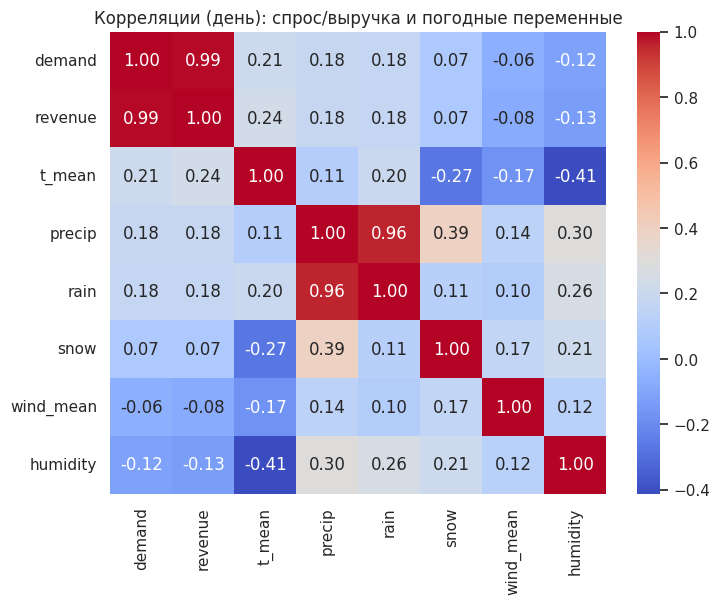

In [ ]:
# EDA по "всему" — суммарные тренды и сезонность
# Общее число проданных блюд и выручка по дате
fig, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
agg_daily_all.set_index('ts')[['demand']].plot(ax=ax[0], title='Суточный спрос (количество блюд)')
agg_daily_all.set_index('ts')[['revenue']].plot(ax=ax[1], title='Суточная выручка (руб.)')
save_plot(filename='Общее число проданных блюд и выручка по дате')
plt.tight_layout()

# 2) Boxplot распределения выручки/спроса по дню недели
daily_wd = agg_daily_all.copy()
daily_wd['dow'] = daily_wd['ts'].dt.dayofweek
plt.figure(figsize=(10,5))
sns.boxplot(x='dow', y='demand', hue= 'dow', data=daily_wd)
plt.title('Распределение спроса по дням недели (сумма за день)')
plt.xlabel('Day of week (0=Mon)')
save_plot(filename='Распределение спроса по дням недели (сумма за день)')
plt.show()

# 3) Heatmap: час x dow по среднему спросу
hour_dow = df.groupby(['hour','dow'])[QTY_COL].sum().unstack().fillna(0)
plt.figure(figsize=(10,6))
sns.heatmap(hour_dow, cmap='viridis')
plt.title('Hour vs DOW: суммарное количество блюд (по часам и дням недели)')
plt.ylabel('hour')
save_plot(filename='Hour vs DOW: суммарное количество блюд')
plt.show()

# 4) Корреляционная матрица между целями и погодой (на дневном уровне)
num_cols = ['demand','revenue','t_mean','precip','rain','snow','wind_mean','humidity']
corr = agg_daily_all.set_index('ts')[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляции (день): спрос/выручка и погодные переменные')
save_plot(filename='Корреляции (день): спрос и выручка и погодные переменные')
plt.show()



Основные временные закономерности:
- спрос и выручка ожидаемо показывают схожую динамику;
- также очевидна сезонность, связанная с повышенным спросом в будние дни и падение в выходные (особенно в воскресенье);
- обеденное время обладает разительно большей популярностью у клиентов, по сравнению с остальным временем;
- коррелляционная матрица показывает, что наибольшее влияние на целевые признаки оказывают: средняя температура, осадки и дождь.

Saved: /content/drive/MyDrive/Cafe_prediction/cafe_plots/Temp vs Demand (sample) + LOWESS_20251002_192807_118332.png


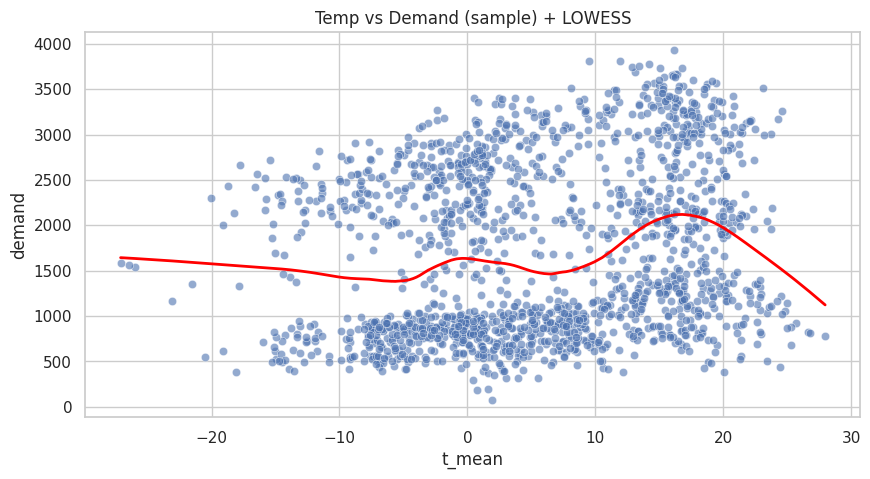

Saved: /content/drive/MyDrive/Cafe_prediction/cafe_plots/Спрос по температурным бинам_20251002_192807_590010.png


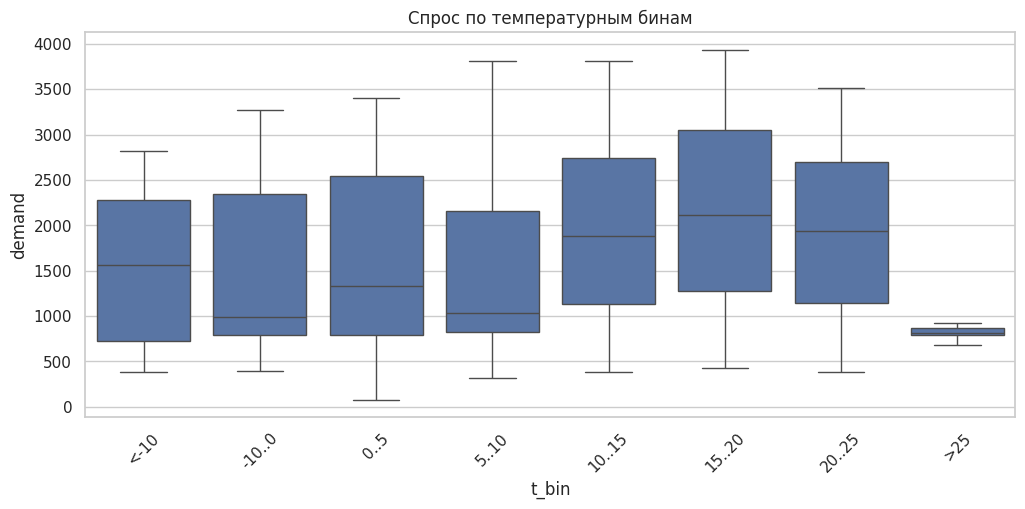

Saved: /content/drive/MyDrive/Cafe_prediction/cafe_plots/Средний спрос в температурных бинах (±SEM)_20251002_192807_973928.png


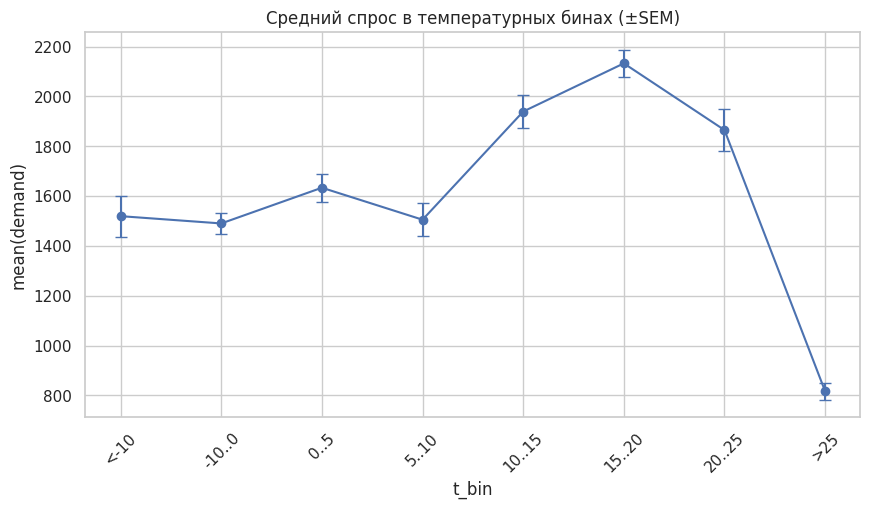

Сравнение спроса: осадки vs без осадков
               mean  median  count
no_precip  1837.60  1694.0    573
precip     1650.32  1377.5   1054


In [ ]:
# безопасный размер выборки
n_sample = min(20000, len(agg_daily_all))
sample_df = agg_daily_all.sample(n_sample, random_state=42)

# Scatter + LOWESS (используем statsmodels lowess для стабильности)
plt.figure(figsize=(10,5))
sns.scatterplot(x='t_mean', y='demand', data=sample_df, alpha=0.6)
# lowess сглаживание
lowess_sm = lowess(sample_df['demand'], sample_df['t_mean'], frac=0.3)
plt.plot(lowess_sm[:,0], lowess_sm[:,1], color='red', linewidth=2)
plt.xlabel('t_mean')
plt.ylabel('demand')
plt.title('Temp vs Demand (sample) + LOWESS')
save_plot(filename='Temp vs Demand (sample) + LOWESS')
plt.show()

# Boxplot спроса по температурным бинам
agg_with_bins = agg_daily_all.assign(
    t_bin = pd.cut(agg_daily_all['t_mean'], bins=temp_bins, labels=temp_labels)
)
plt.figure(figsize=(12,5))
sns.boxplot(x='t_bin', y='demand', data=agg_with_bins)
plt.title('Спрос по температурным бинам')
plt.xticks(rotation=45)
save_plot(filename='Спрос по температурным бинам')
plt.show()

# Binned mean + SEM (показывает тренд и разброс)
binned = (agg_with_bins
          .groupby('t_bin')['demand']
          .agg(['mean', 'count', 'std'])
          .reset_index()
          .dropna())
binned['sem'] = binned['std'] / np.sqrt(binned['count'])
plt.figure(figsize=(10,5))
plt.errorbar(x=binned['t_bin'].astype(str), y=binned['mean'], yerr=binned['sem'], fmt='o-', capsize=4)
plt.xlabel('t_bin')
plt.ylabel('mean(demand)')
plt.title('Средний спрос в температурных бинах (±SEM)')
plt.xticks(rotation=45)
save_plot(filename='Средний спрос в температурных бинах (±SEM)')
plt.show()

# Сравнение спроса в дни с осадками и без (без ошибок, защищаемся от NaN в precip)
agg_daily_all['precip'] = agg_daily_all['precip'].fillna(0)
precip_cmp = agg_daily_all.groupby((agg_daily_all['precip'] > 0).astype(int))['demand'].agg(['mean','median','count'])
precip_cmp.index = ['no_precip','precip']
print("Сравнение спроса: осадки vs без осадков\n", precip_cmp)


Основные температурные закономерности:
- наибольший спрос приходится на температуру от 10 до 25 градусов по цельсию;
- отмечается снижение спроса при температуре от 5 до 10 и совсем низкий спрос при температуре более 25 градусов по цельсию;
- средний и медианный спрос без осадках немного превышает спрос при их наличии.

Top stores: ['Энгельса', 'Свердлова', 'Плаза', 'Тетрис', 'Анохина']
Report for: Энгельса
          count       mean       std  min       25%      50%       75%  \
demand   1627.0    1040.30    551.65  0.0    691.00    865.0    1167.0   
revenue  1627.0  115098.15  63210.04  0.0  73837.07  96376.0  132260.0   

              max  
demand     3079.0  
revenue  329727.1  


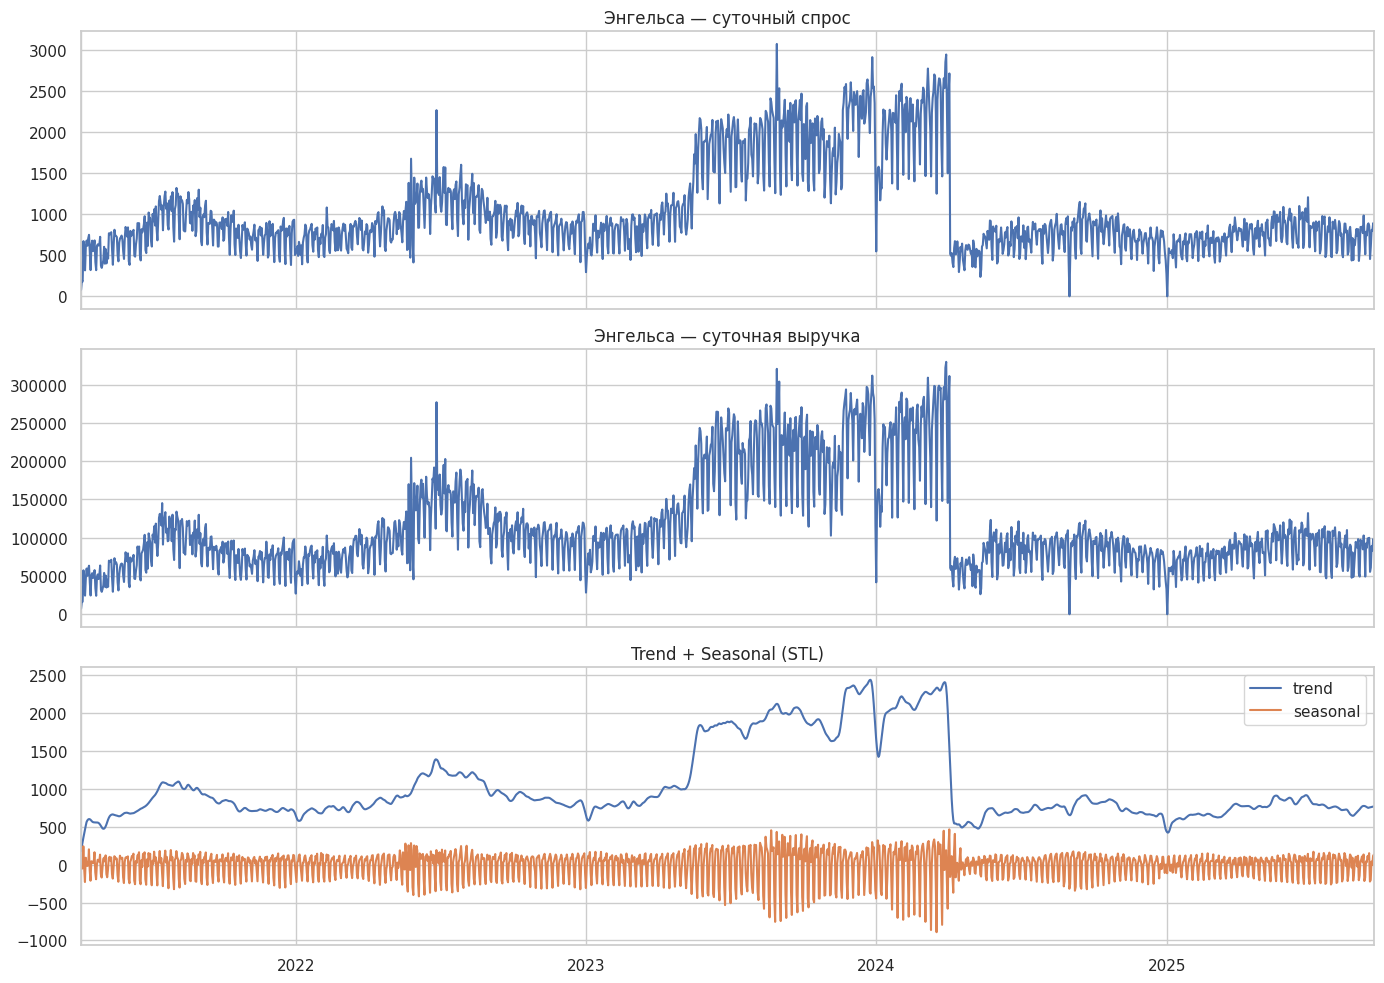

Report for: Свердлова
         count       mean       std  min       25%        50%        75%  \
demand   534.0     951.90    227.40  0.0    801.50     955.50    1116.00   
revenue  534.0  103123.24  24875.15  0.0  87240.44  103952.18  121845.23   

              max  
demand     1479.0  
revenue  183702.0  


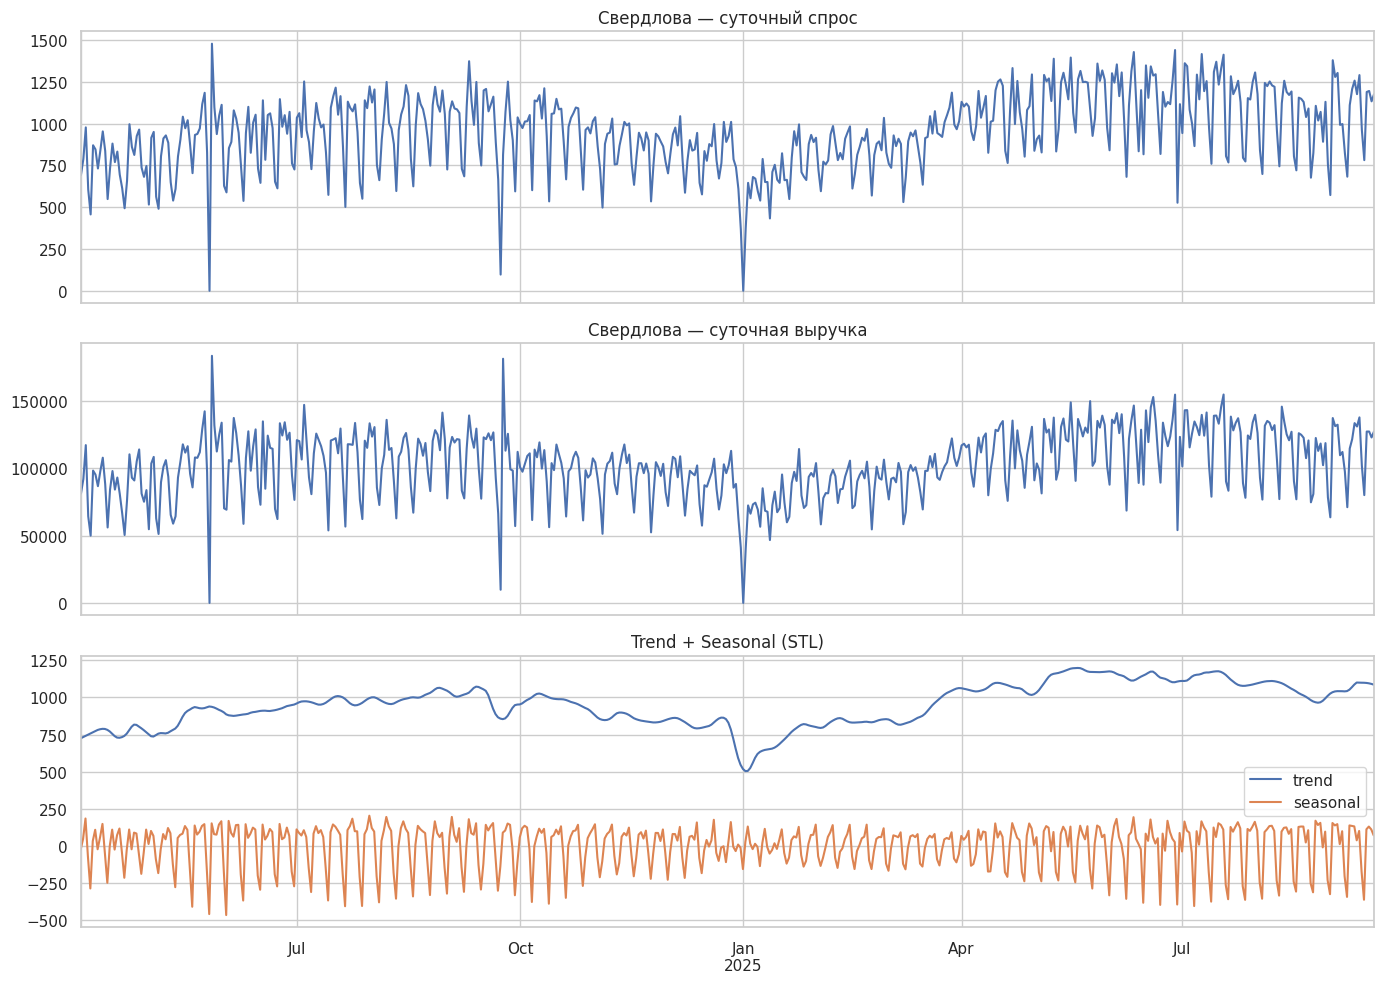

Report for: Плаза
         count      mean       std      min      25%      50%       75%  \
demand   533.0    768.02    114.68    311.0    700.0    769.0    832.00   
revenue  533.0  85911.73  13181.01  26638.5  79018.0  86525.5  94072.01   

              max  
demand     1237.0  
revenue  131999.0  


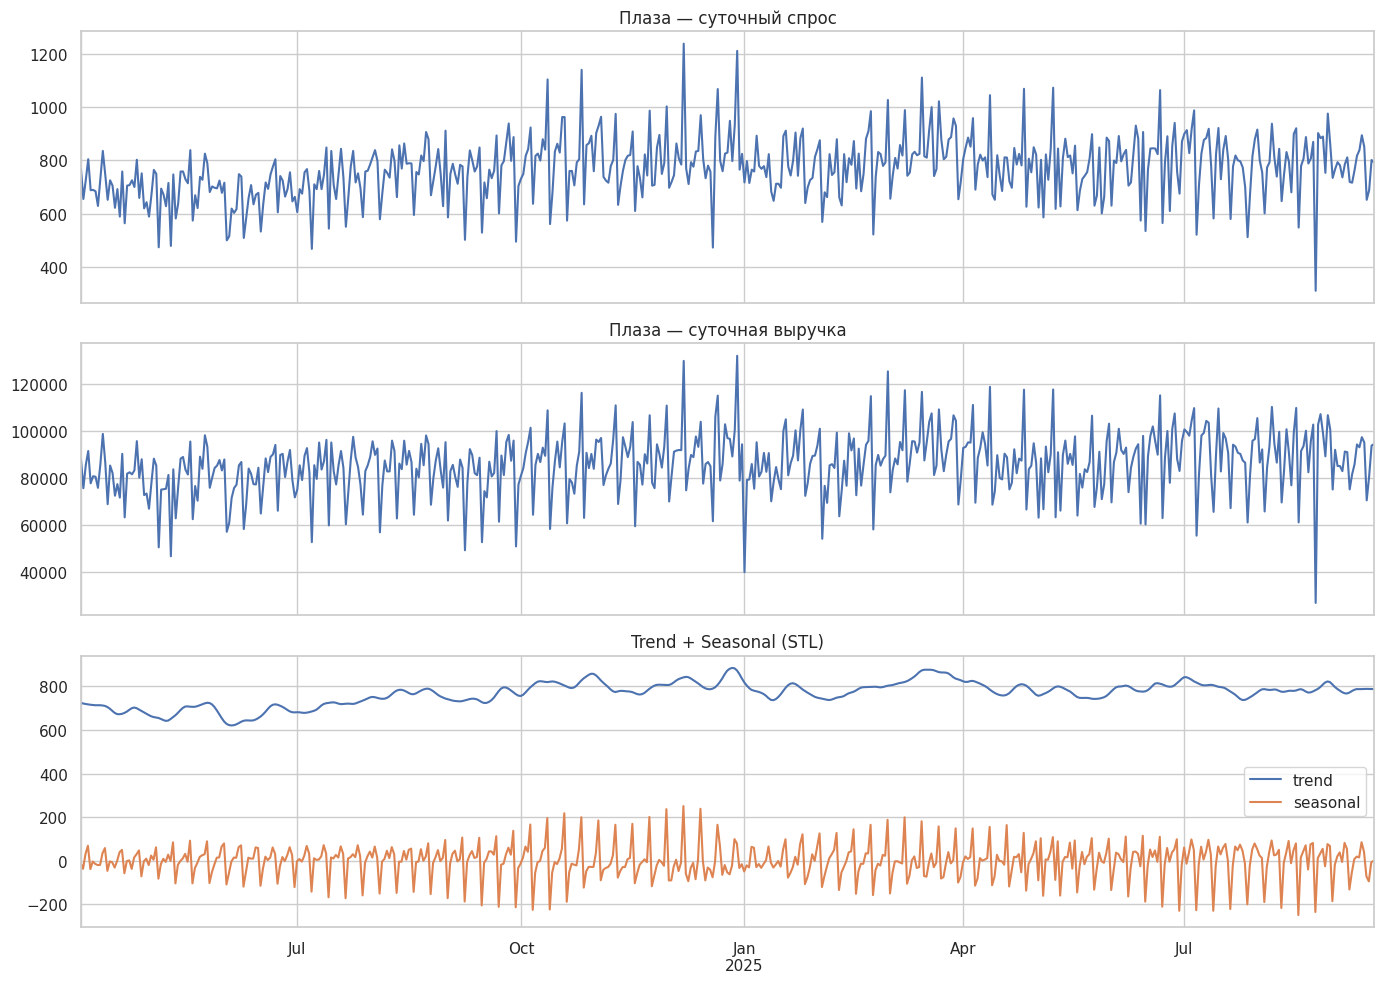

Report for: Тетрис
         count      mean       std  min      25%      50%       75%      max
demand   534.0    312.07     81.38  0.0    258.0    316.0    366.75    631.0
revenue  534.0  35568.95  11057.93  0.0  27568.0  37451.0  42920.50  74843.0


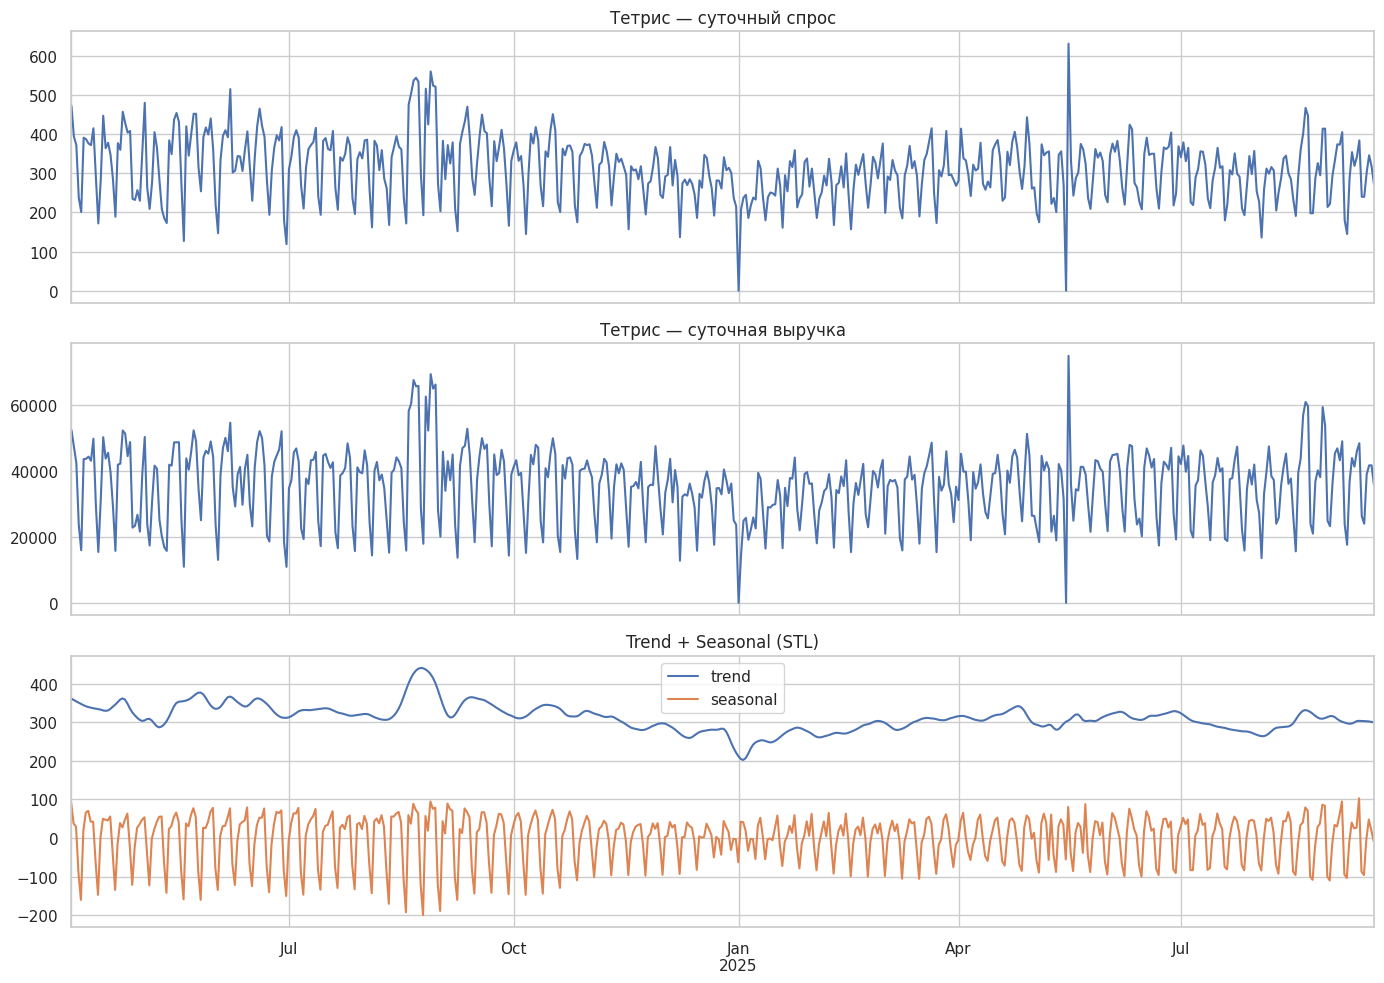

Report for: Анохина
         count      mean       std  min       25%       50%       75%      max
demand    56.0    276.89    165.38  0.0    181.00    317.50    403.25    507.0
revenue   56.0  31586.24  19752.58  0.0  17745.68  38650.38  48461.09  57241.5


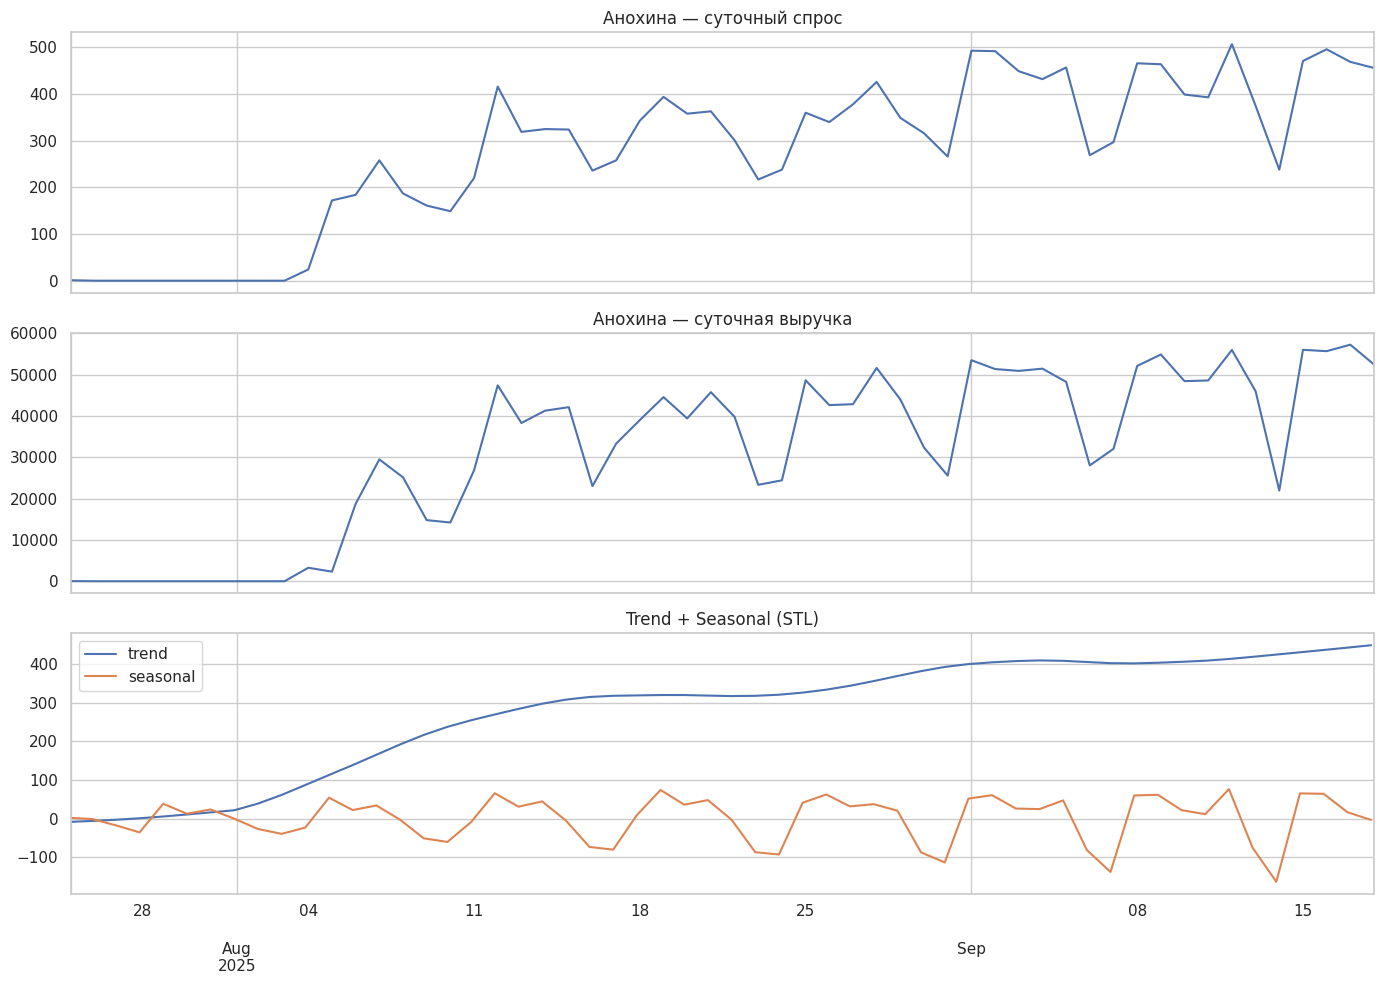

In [ ]:
# EDA по каждому Торговое предприятие — генерируем отчёт/графики для топ-N по объёму продаж
OUTPUT_DIR = 'store_reports'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# выбираем топ-N магазинов по сумме продаж (или по количеству строк)
top_n = 10
top_stores = df.groupby(STORE_COL)[QTY_COL].sum().sort_values(ascending=False).head(top_n).index.tolist()
print("Top stores:", top_stores)

def store_report(store_name, save_png=True):
    sub = df[df[STORE_COL] == store_name]
    # агрегируем по дням для магазина
    agg = aggregate_by_freq(sub, freq='D', store=store_name)
    # краткая статистика
    print(f"Report for: {store_name}")
    print(agg[['demand','revenue']].describe().T)
    # 1) временной ряд спроса
    fig, axs = plt.subplots(3,1, figsize=(14,10), sharex=True)
    agg.set_index('ts')['demand'].plot(ax=axs[0], title=f'{store_name} — суточный спрос')
    agg.set_index('ts')['revenue'].plot(ax=axs[1], title=f'{store_name} — суточная выручка')
    # 2) seasonal decomposition (если ряд не сильно разрежен)
    try:
        stl = STL(agg.set_index('ts')['demand'].fillna(0), period=7)
        res = stl.fit()
        axs[2].plot(res.trend.index, res.trend, label='trend')
        axs[2].plot(res.seasonal.index, res.seasonal, label='seasonal')
        axs[2].legend()
        axs[2].set_title('Trend + Seasonal (STL)')
    except Exception as e:
        axs[2].text(0.1,0.5,"STL failed: "+str(e))
    plt.tight_layout()
    if save_png:
        plt.savefig(os.path.join(save_dir, f"{store_name}_timeseries.png"))
    plt.show()

# Генерируем отчёты для топ-N
for s in top_stores:
    store_report(s, save_png=True)
    gc.collect()


In [ ]:
# Соберём дневные агрегаты для всех предприятий
daily_top = pd.concat([aggregate_by_freq(df, freq='D', store=s).assign(store=s) for s in top_stores], ignore_index=True)
fig = px.line(daily_top, x='ts', y='demand', color='store', title='Daily demand — top stores')
save_plot(filename='Daily demand — top stores')
fig.show()


Saved: /content/drive/MyDrive/Cafe_prediction/cafe_plots/Daily demand — top stores_20251002_192830_081421.png


<Figure size 1000x500 with 0 Axes>

По вышеуказанным графикам можно сделать следующие выводы:
1. Во всех случаях наблюдается явно выраженная сезонность, в первую очередь, которая связана со спросом в будние и выходные дни. Тренд неочевиден.
2. До марта 2024 года было только одно предприятие - Энгельса. Примечательно то, что ни одно из 4 новых предприятий не смогли повторить индивидуальные показатели Энгельса по спросу и выручке до марта 2024 года (особенно в период с мая 2023 по март 2024). Будто клиенты Энгельса затем распределились по остальным точкам, что сомнительно, ведь предприятия находятся в разных местах города. После марта 2024 года спрос распределился в следующей последовательности по убыванию: Свердлова, Плаза, Энгельса, Тетрис, Анохина.

Top dishes:
 Блюдо_canonical
капучино                  547826
коровье                   236573
салат цезарь с курицеи    108891
американо                  81924
карбонара паста            69706
калитка брусника           63558
суп сырныи крем            61408
сироп                      52914
чаи в чашке                47865
с собои                    44407
Name: Количество блюд, dtype: int64
Saved: /content/drive/MyDrive/Cafe_prediction/cafe_plots/Daily demand for top-10 dishes_20251002_192832_101996.png


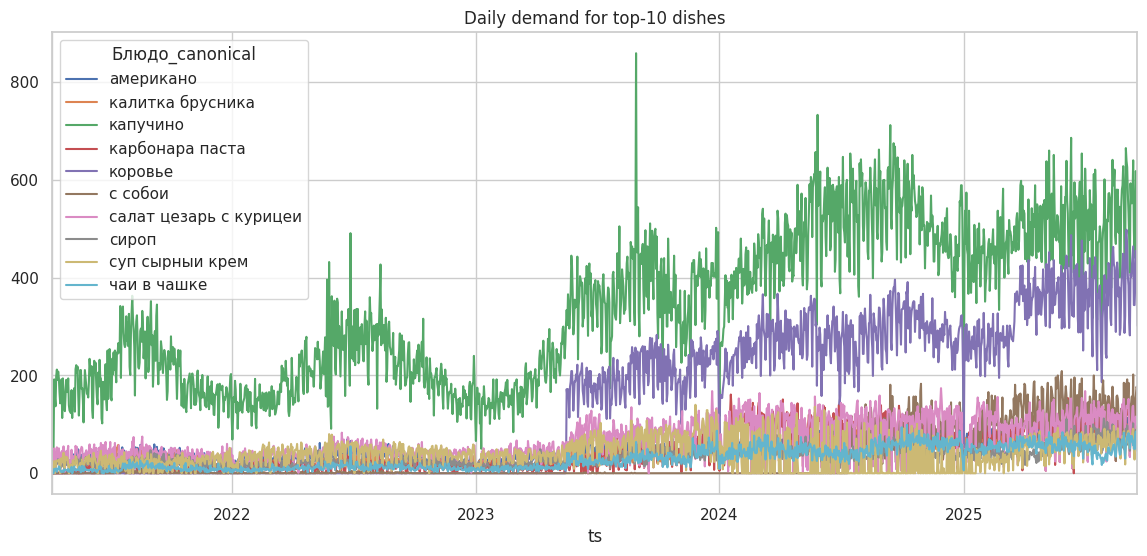

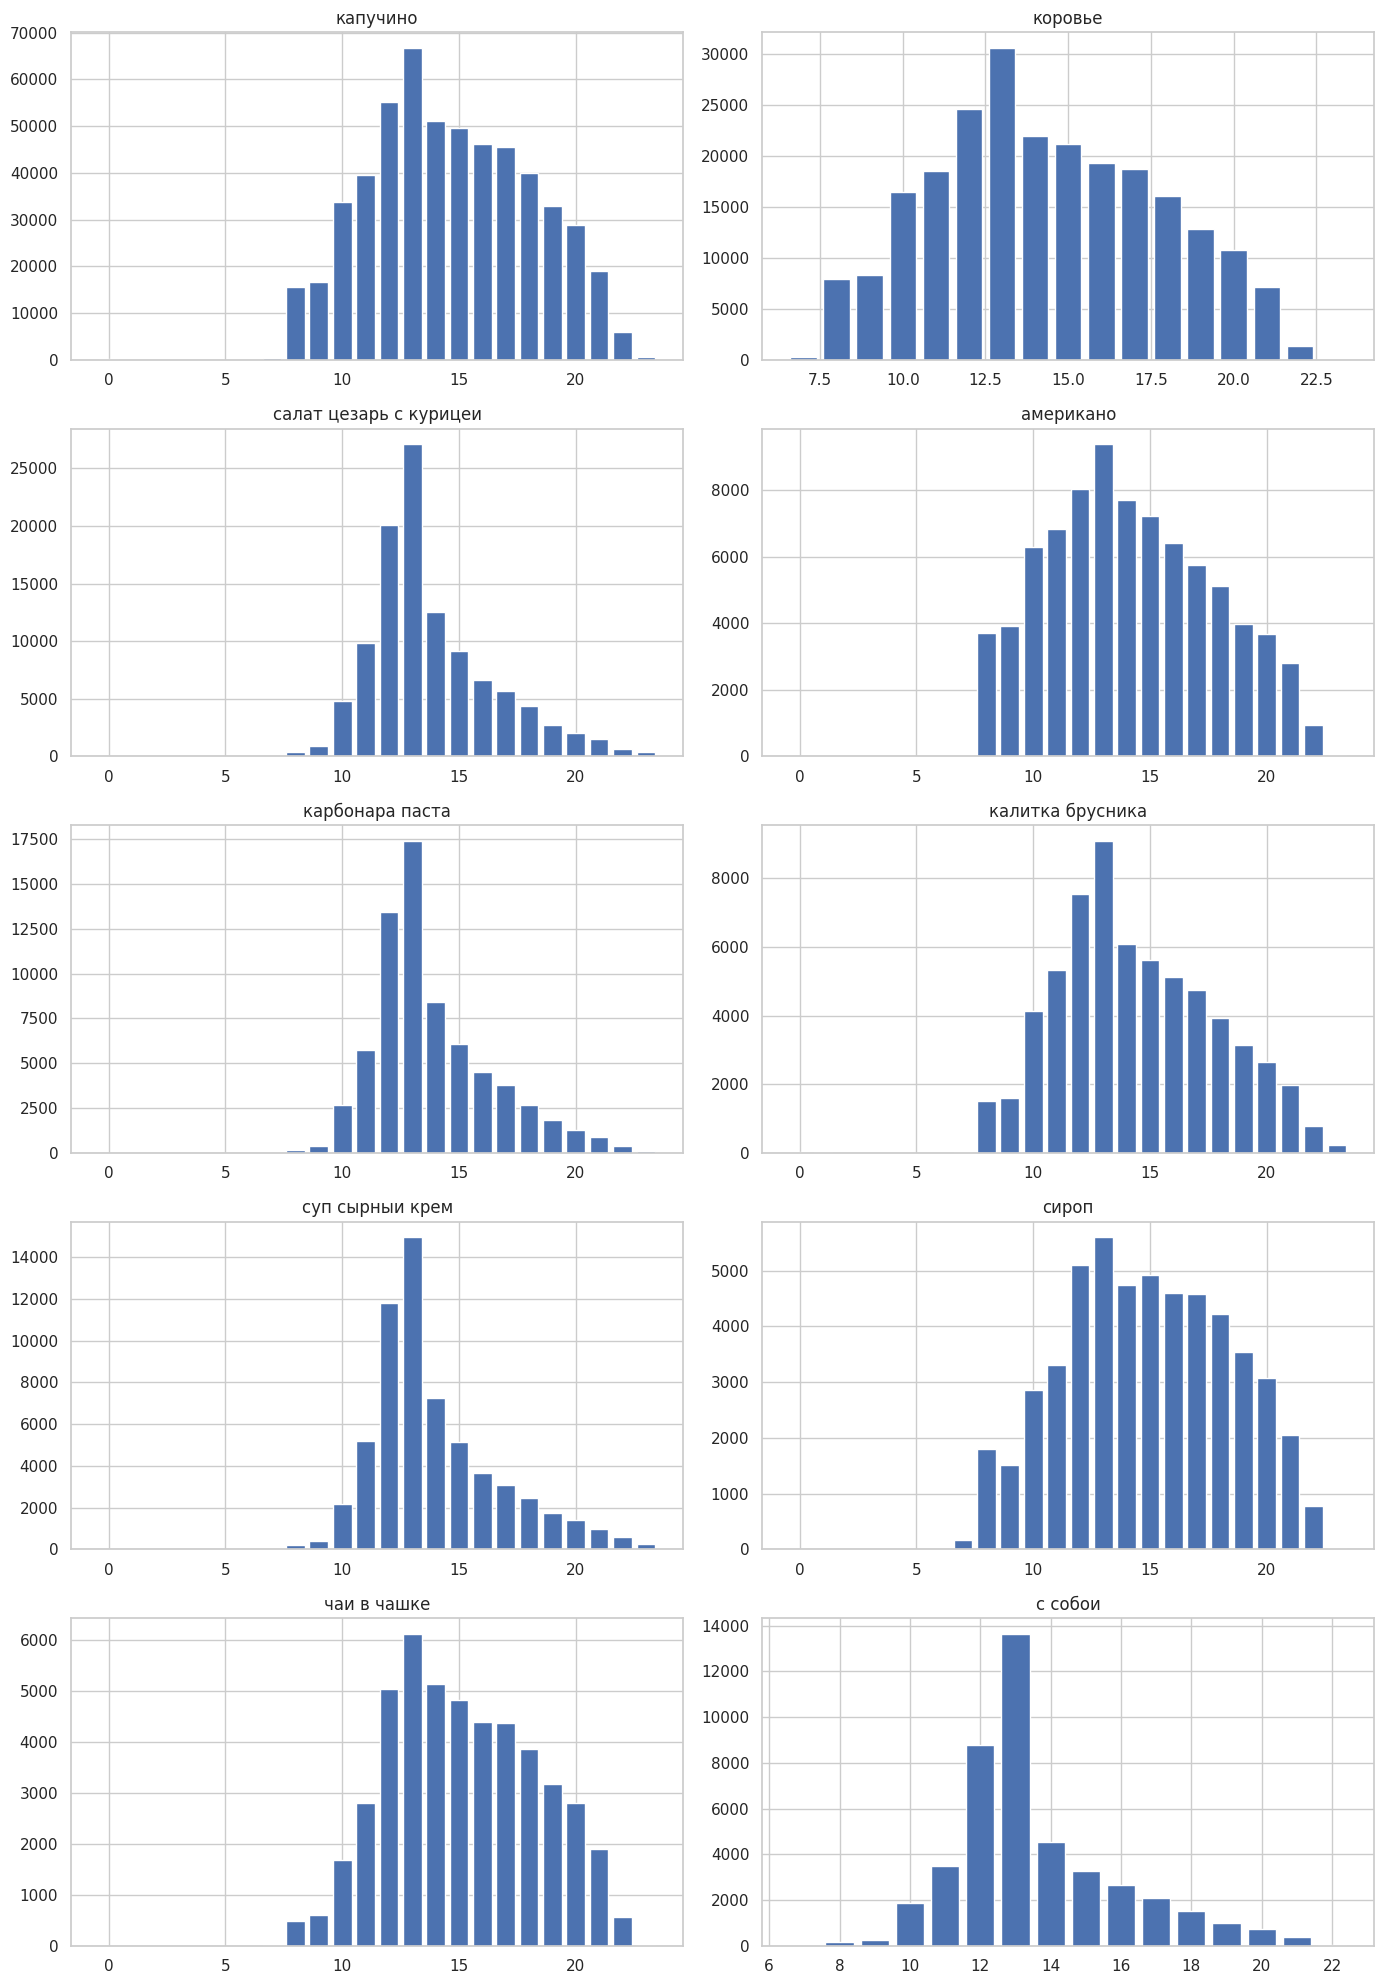

In [ ]:
# Анализ по блюдам (Блюдо_canonical) — топ-блюда и сезонность
# Топ-блюда по сумме проданного количества
top_items = df.groupby('Блюдо_canonical')[QTY_COL].sum().sort_values(ascending=False).head(10)
print("Top dishes:\n", top_items)

# Для топ-10 блюд построим временной ряд (дни)
top_items_list = top_items.head(10).index.tolist()
daily_items = (df_sorted[df_sorted['Блюдо_canonical'].isin(top_items_list)]
               .groupby([pd.Grouper(key='ts', freq='D'), 'Блюдо_canonical'])[QTY_COL]
               .sum().unstack().fillna(0))
daily_items.plot(figsize=(14,6), title='Daily demand for top-10 dishes')
save_plot(filename='Daily demand for top-10 dishes')
plt.show()

# Hour vs day_time распределение для топ-10 блюд
fig, axs = plt.subplots(5,2, figsize=(14,20))
axs = axs.flatten()
for i, item in enumerate(top_items_list):
    tmp = df_sorted[df_sorted['Блюдо_canonical']==item].groupby(['hour'])[QTY_COL].sum()
    axs[i].bar(tmp.index, tmp.values)
    axs[i].set_title(item)
plt.tight_layout()


Среди блюд с отрывом лидируют Американо (кофе) и Коровье (молоко). Распределение у топ 10 блюд нормальное.

count       mean        std      min        50%        max
demand     1627.0    1716.28     939.28    78.00    1467.00    3934.00
revenue    1627.0  189850.09  106707.83  7258.00  169577.00  439419.22
hour       1627.0      14.56       0.64    11.03      14.40      18.34
t_mean     1627.0       5.69      10.21   -27.11       5.05      27.97
precip     1627.0    3017.55    6405.02     0.00     495.00   63146.50
rain       1627.0    2464.05    5923.58     0.00     282.34   58713.60
snow       1627.0     553.64    1853.24     0.00       0.00   23401.35
wind_mean  1627.0      13.26       5.07     2.67      12.77      31.18
humidity   1627.0      78.66      11.03    43.29      80.67     100.00

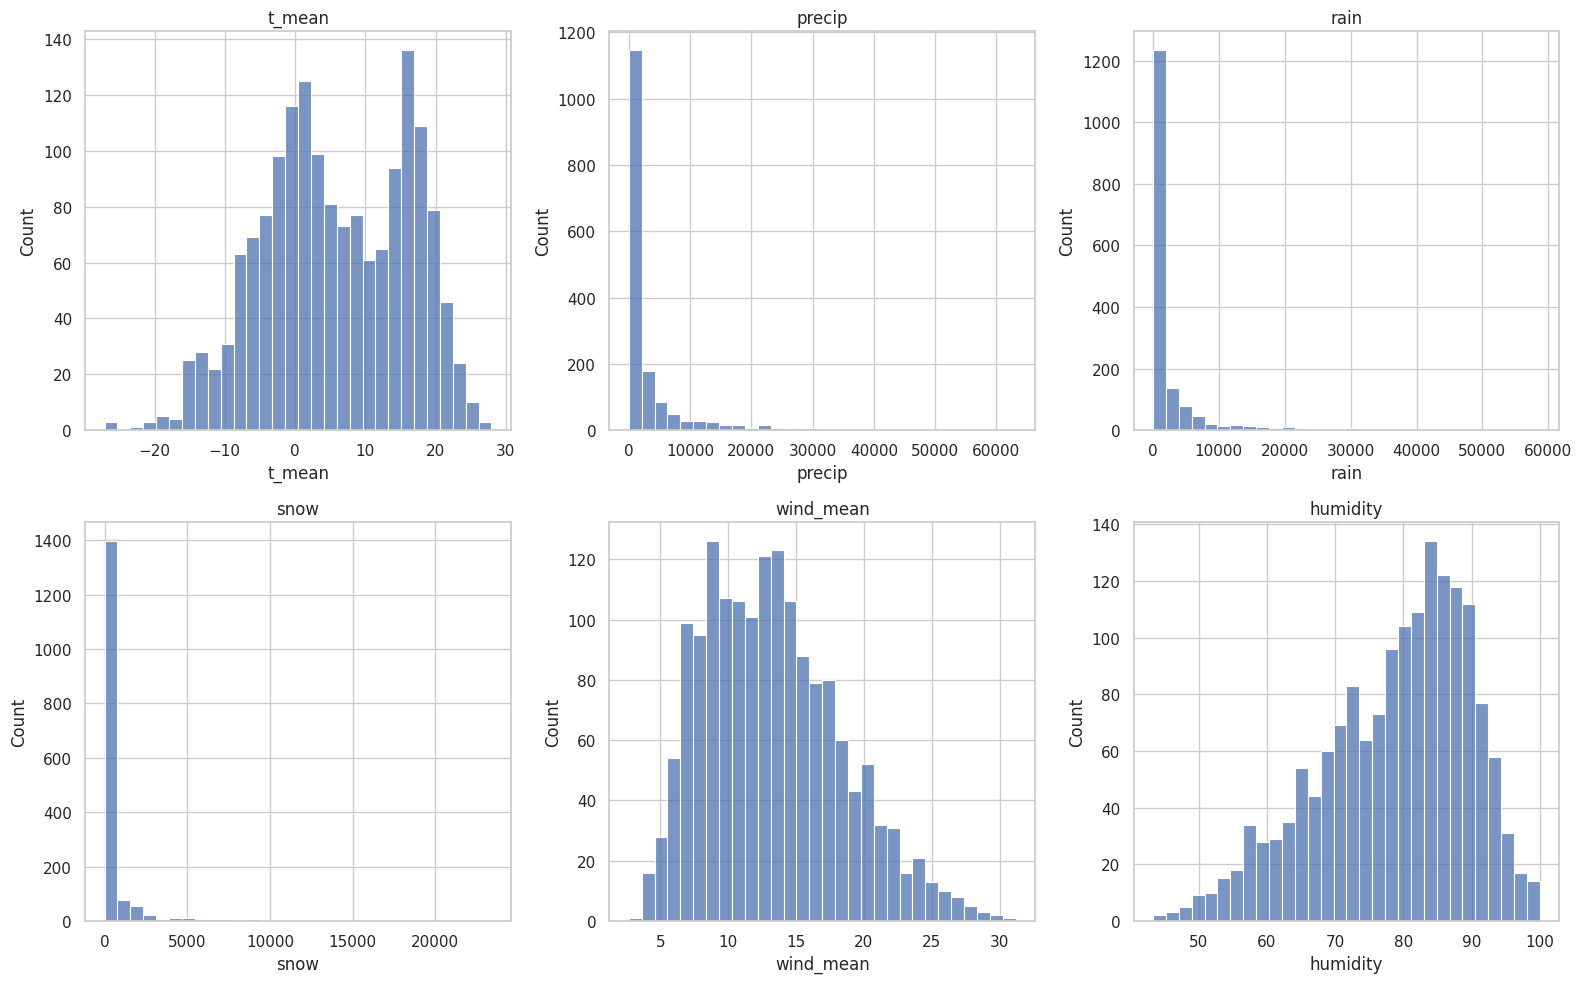

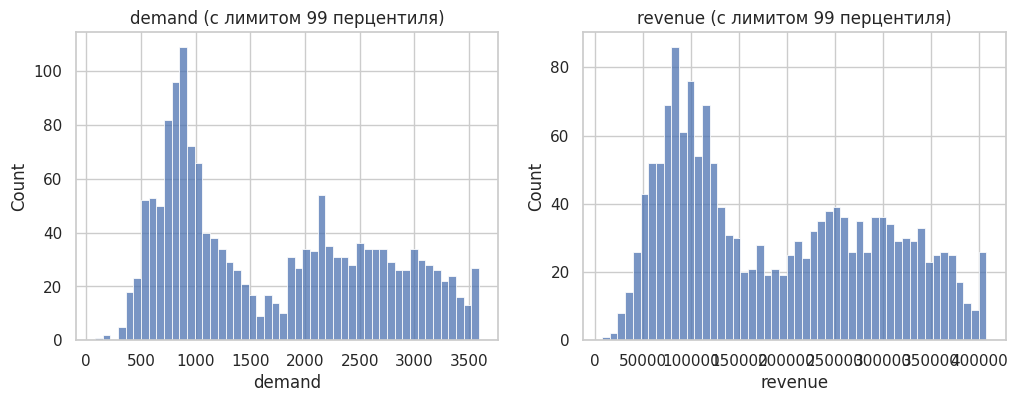

In [ ]:
display(agg_daily_all.describe().T[['count','mean','std','min','50%','max']])

fig, axs = plt.subplots(2, 3, figsize=(16,10))
vars_weather = ['t_mean','precip','rain','snow','wind_mean','humidity']
for ax, v in zip(axs.flatten(), vars_weather):
    sns.histplot(agg_daily_all[v].dropna(), kde=False, ax=ax, bins=30)
    ax.set_title(v)
plt.tight_layout()
plt.show()

# спрос и выручка
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.histplot(agg_daily_all['demand'].clip(upper=agg_daily_all['demand'].quantile(0.99)), bins=50, ax=axs[0])
axs[0].set_title('demand (c лимитом 99 перцентиля)')
sns.histplot(agg_daily_all['revenue'].clip(upper=agg_daily_all['revenue'].quantile(0.99)), bins=50, ax=axs[1])
axs[1].set_title('revenue (c лимитом 99 перцентиля)')
plt.show()


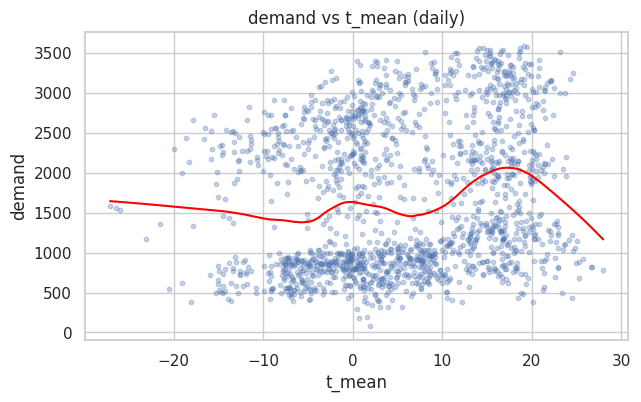

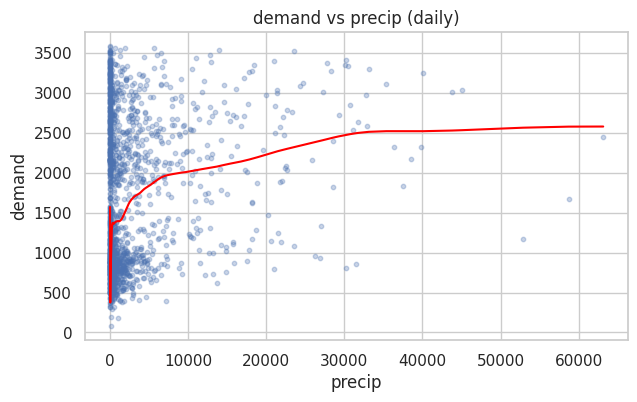

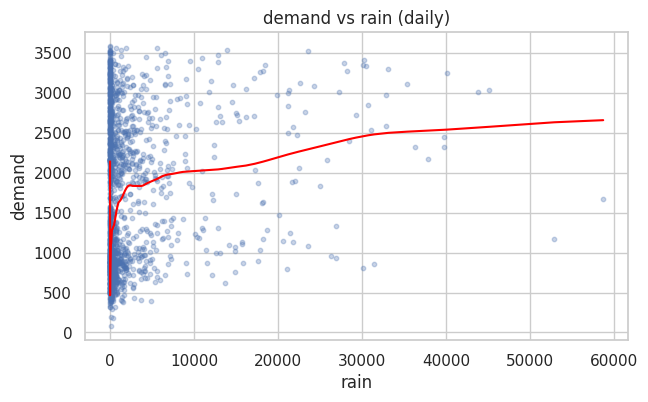

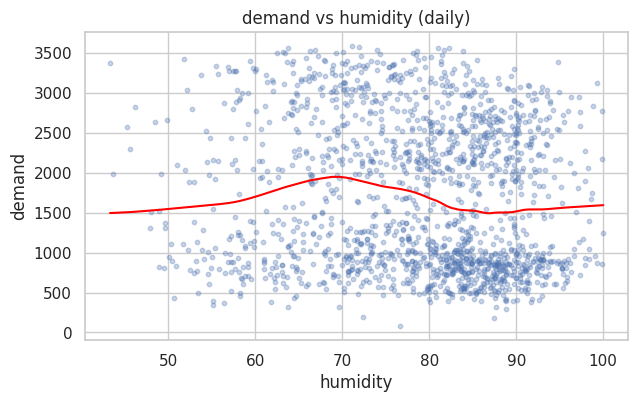

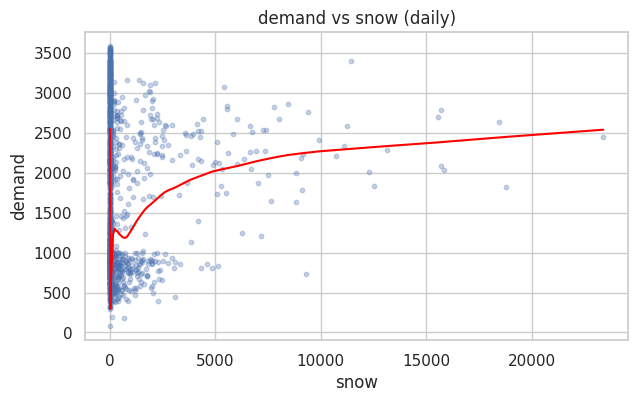

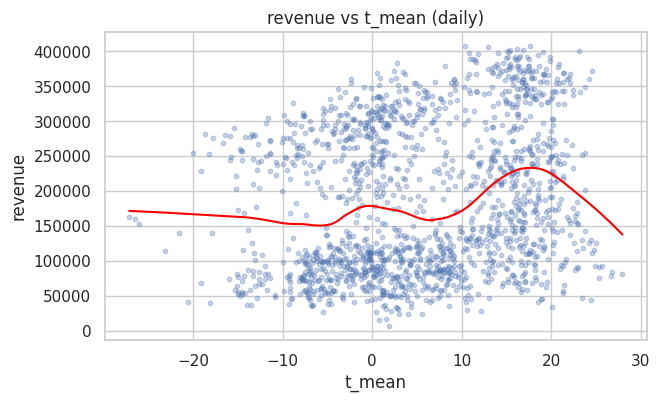

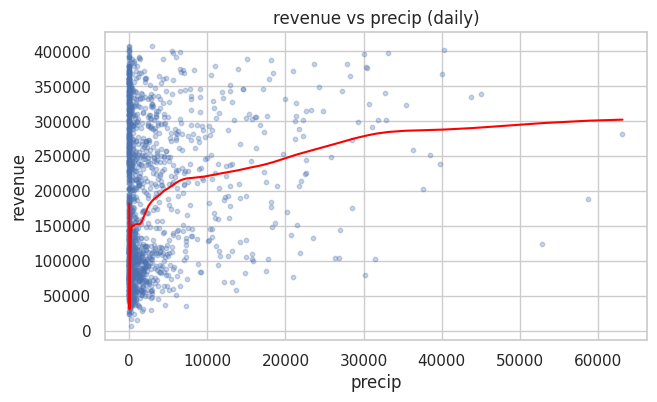

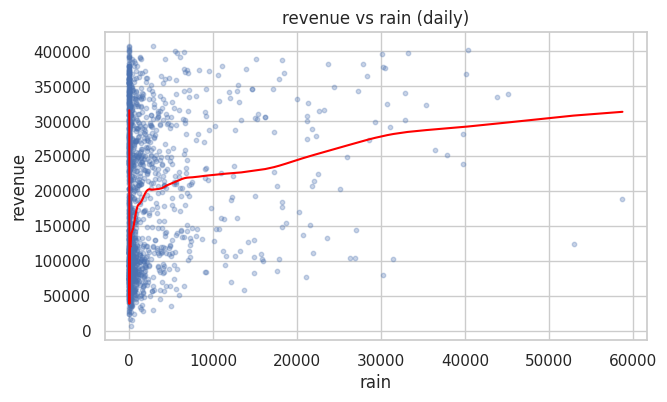

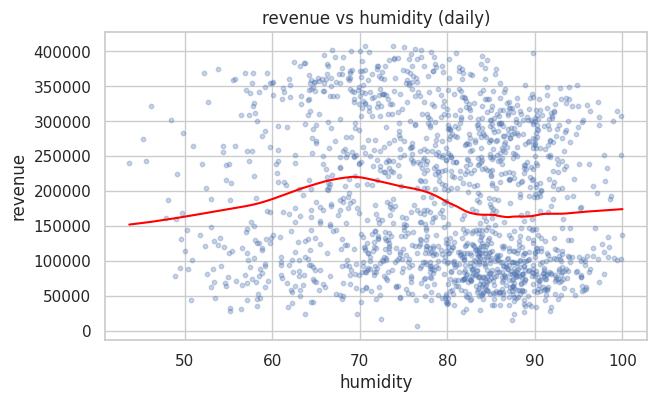

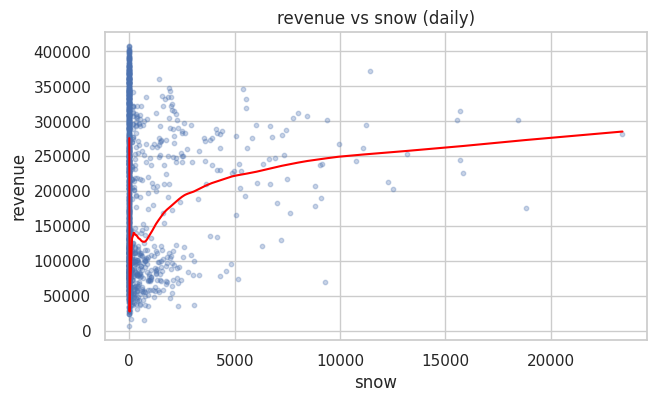

In [ ]:
# scatter + LOWESS smoothing for main weather vars
plot_vars = ['t_mean','precip','rain','humidity','snow']
targets = ['demand','revenue']
for target in targets:
    for v in plot_vars:
        data = agg_daily_all[[v, target]].dropna()
        # ограничим экстремумы для визуализации, если нужно
        data = data[data[target] <= data[target].quantile(0.99)]
        plt.figure(figsize=(7,4))
        plt.scatter(data[v], data[target], alpha=0.3, s=10)
        # lowess
        smoothed = lowess(data[target], data[v], frac=0.3)
        plt.plot(smoothed[:,0], smoothed[:,1], color='red')
        plt.xlabel(v); plt.ylabel(target)
        plt.title(f'{target} vs {v} (daily)')
        plt.show()

По результатам анализа основных показателей заметны явные выбросы в признаках 'precip', 'rain', 'snow'. Это погодные показатели, пока очищать от выбросов не будем.

Сохраняем получившийся датасет

In [ ]:
df.to_csv(OUTPUT_CSV, index=False)
print('Saved df file to', OUTPUT_CSV)

Saved df file to /content/drive/MyDrive/Cafe_prediction/cafe_f_engin_EDA.csv
